<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_ACF_PACF_LjungBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TSLA 시계열 진단: ACF/PACF + Ljung–Box (가격/수익률, 잔차/제곱잔차)

이 노트북은 다음을 한 번에 수행합니다.

1. **데이터 수집**: `yfinance`로 TSLA 일별 종가 다운로드  
2. **변환**: 가격(레벨)과 로그수익률(%) 생성  
3. **시각화**: 가격/수익률 차트, **ACF/PACF** (가격·수익률·ARIMA 잔차)  
4. **Ljung–Box 검정**:  
   - 가격 vs 수익률 (여러 시차)  
   - **ARIMA(1,1,1) 잔차** → 백색잡음 여부  
   - **잔차 제곱** → ARCH(변동성 군집) 징후

> 귀무가설 H₀: “선택한 시차까지 **자기상관이 없다**(백색잡음)”.  
> p-value < 0.05 이면 **기각(유의)**, 아니면 **기각 실패(유의 아님)** 로 표시합니다.


# Ljung–Box(륑–박스) 검정

## 무엇을 테스트하나?

* **귀무가설 H₀:** 시계열이 **백색잡음**(white noise)이다 → **선택한 여러 시차(1…h)에서 자기상관이 모두 0**
* **대립가설 H₁:** 최소 하나의 시차에서 자기상관이 0이 아니다

즉, “여러 시차의 자기상관을 한꺼번에” 검정하는 **포트만토(portmanteau)** 테스트입니다.

## 통계량

표본 크기 (n), 샘플 자기상관 (r_k) (lag k), 검정 최대 시차 (h)일 때

* **Box–Pierce 통계량(원형)**
  
  $$Q_{\text{BP}} = n \sum_{k=1}^{h} r_k^2$$
  

* **Ljung–Box 통계량(수정형, 표준)**

  $$Q_{\text{LB}} = n(n+2)\sum_{k=1}^{h}\frac{r_k^2}{,n-k,}$$
  

$(H_0)$ 하에서 $(Q_{\text{LB}} \sim \chi^2_{\nu})$ (큰 표본 근사).

* **원자료(모형 적합 전)**: $(\nu = h)$
* **ARMA/ARIMA 잔차**: $(\nu = h - m)$ (모형 추정된 모수 수 보정; 보통 (m=p+q))

## 해석법

* **p-value < α (예: 0.05)** → H₀ 기각 → “선택한 시차들 중 어딘가에 **자기상관이 유의**”
* **p-value ≥ α** → H₀ 기각 실패 → “그 정도로는 자기상관이 있다고 보기 어렵다”

> 주의: **가격(레벨)** 은 비정상/추세 때문에 대개 H₀가 **기각**됩니다.
> **수익률(또는 모형 잔차)** 이 진단용으로 적절합니다.

## 언제/어디에 쓰나?

1. **원 시계열 진단**: 가격보다는 **수익률**에서 자기상관 존재 여부 점검
2. **모형 잔차 진단**: ARIMA·SARIMA·VAR 등을 적합한 후 잔차가 백색잡음인지 검정
3. **이분산 점검 보조**: 잔차의 **제곱**(또는 절대값)에도 Ljung–Box를 적용 → **ARCH 효과** 탐지

## 시차 h 선택 요령

* 일반: 10, 20 같은 작은 여러 개를 함께 본다(보고서에 둘 다 제시)
* 표본 크기 $(n)$에 비해 너무 크지 않게: $(h \approx \sqrt{n})$ 또는 $(h \approx \log n)$ 관용
* **계절성 존재**: 계절 주기(예: 주간=5, 월간=12)의 배수를 포함해 본다(예: 12, 24)



In [1]:

# ============================================================
# 설치 (Colab에서 한 번만 실행)
# ============================================================
%%capture
%pip install -U yfinance statsmodels matplotlib pandas scikit-learn


In [2]:

# ============================================================
# 임포트 & 경고 억제
# ============================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True


[*********************100%***********************]  1 of 1 completed


TSLA: 501 prices | 2022-01-03 ~ 2023-12-29
Returns: 500 obs


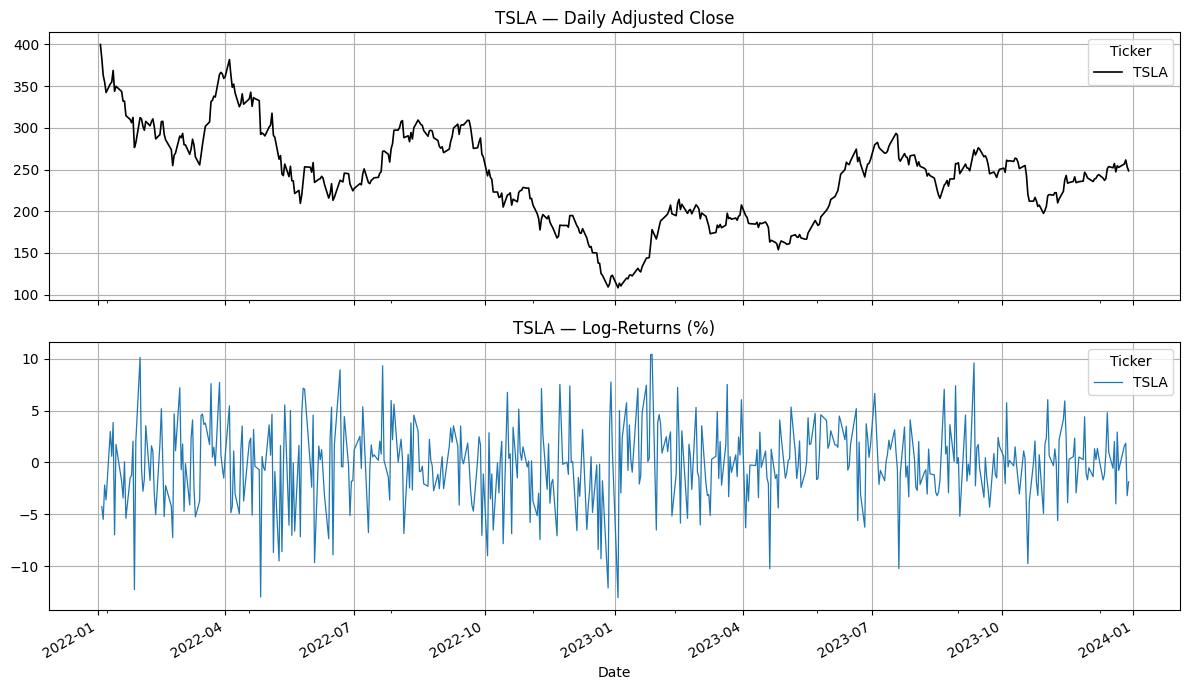

In [3]:

# ============================================================
# 데이터 다운로드 (TSLA)
# ============================================================
symbol = "TSLA"
start  = "2022-01-01"
end    = "2024-01-01"

df = yf.download(symbol, start=start, end=end, auto_adjust=True)
price = df["Close"].dropna().copy()
ret   = np.log(price).diff().dropna() * 100  # 로그수익률(%)

print(f"{symbol}: {len(price)} prices | {price.index[0].date()} ~ {price.index[-1].date()}")
print(f"Returns: {len(ret)} obs")

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
price.plot(ax=ax[0], color="black", lw=1.2, title=f"{symbol} — Daily Adjusted Close")
ret.plot(ax=ax[1], color="tab:blue", lw=0.9, title=f"{symbol} — Log-Returns (%)")
plt.tight_layout(); plt.show()


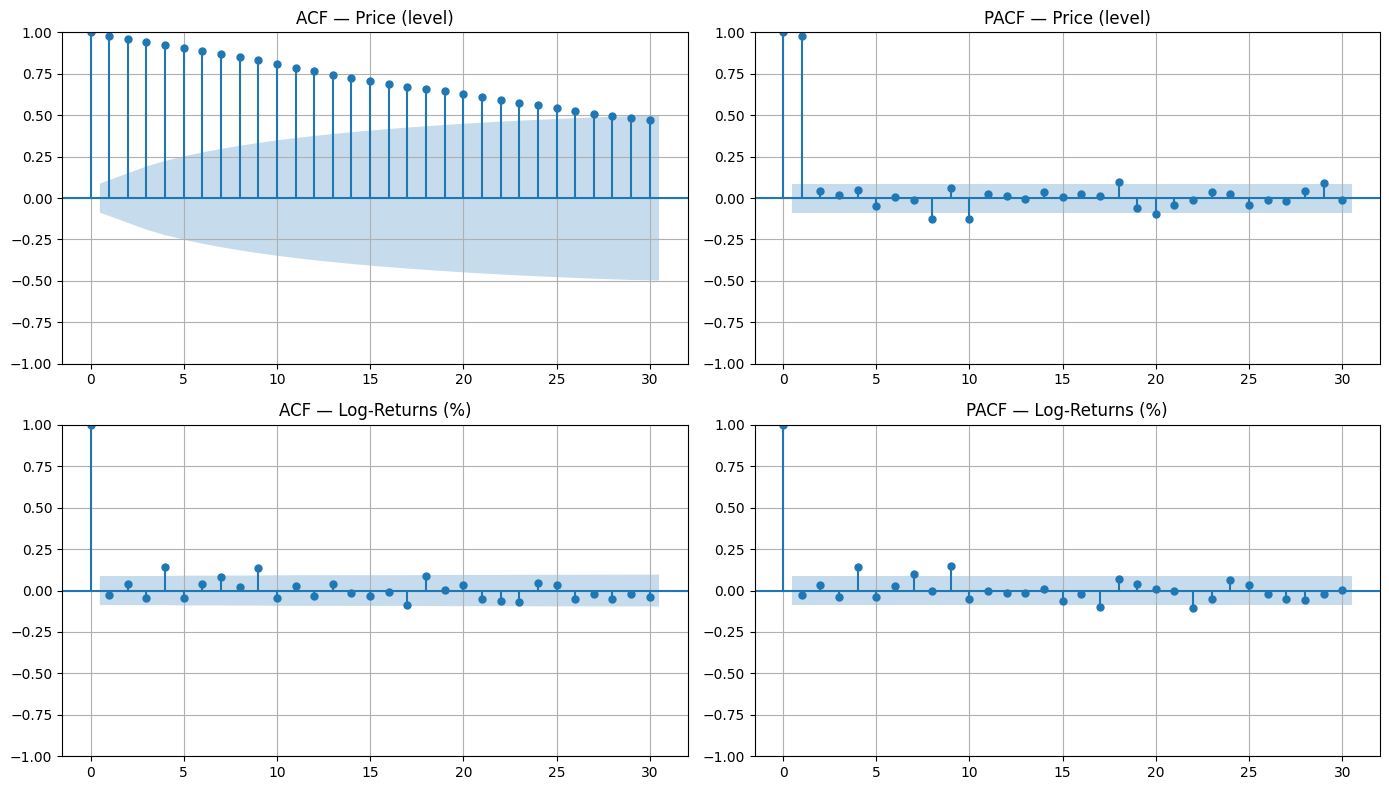

In [4]:

# ============================================================
# ACF / PACF (가격 & 수익률)
# ============================================================
lags = 30

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
plot_acf(price, lags=lags, ax=axes[0,0]); axes[0,0].set_title("ACF — Price (level)")
plot_pacf(price, lags=lags, ax=axes[0,1], method="ywm"); axes[0,1].set_title("PACF — Price (level)")
plot_acf(ret,   lags=lags, ax=axes[1,0]); axes[1,0].set_title("ACF — Log-Returns (%)")
plot_pacf(ret,   lags=lags, ax=axes[1,1], method="ywm"); axes[1,1].set_title("PACF — Log-Returns (%)")
plt.tight_layout(); plt.show()


In [5]:

# ============================================================
# Ljung–Box 헬퍼: 표+판정
# ============================================================
def ljungbox_report(x, name, lags=(10, 20), alpha=0.05):
    res = acorr_ljungbox(x, lags=lags, return_df=True)
    rep = res.rename(columns={"lb_stat":"LB stat", "lb_pvalue":"p-value"}).copy()
    rep[f"decision@α={alpha}"] = np.where(
        rep["p-value"] < alpha,
        "Reject H0 → 자기상관 '있음'(유의)",
        "Fail to reject H0 → 근거 부족(유의 아님)"
    )
    print(f"\n[Ljung–Box] {name}")
    print(rep.to_string())
    return rep

lb_price = ljungbox_report(price, "Price (level)", lags=(10, 20), alpha=0.05)
lb_ret   = ljungbox_report(ret,   "Log-Returns (%)", lags=(10, 20), alpha=0.05)



[Ljung–Box] Price (level)
        LB stat  p-value            decision@α=0.05
10  4088.978084      0.0  Reject H0 → 자기상관 '있음'(유의)
20  6656.730255      0.0  Reject H0 → 자기상관 '있음'(유의)

[Ljung–Box] Log-Returns (%)
      LB stat   p-value            decision@α=0.05
10  28.355515  0.001583  Reject H0 → 자기상관 '있음'(유의)
20  39.390733  0.005960  Reject H0 → 자기상관 '있음'(유의)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


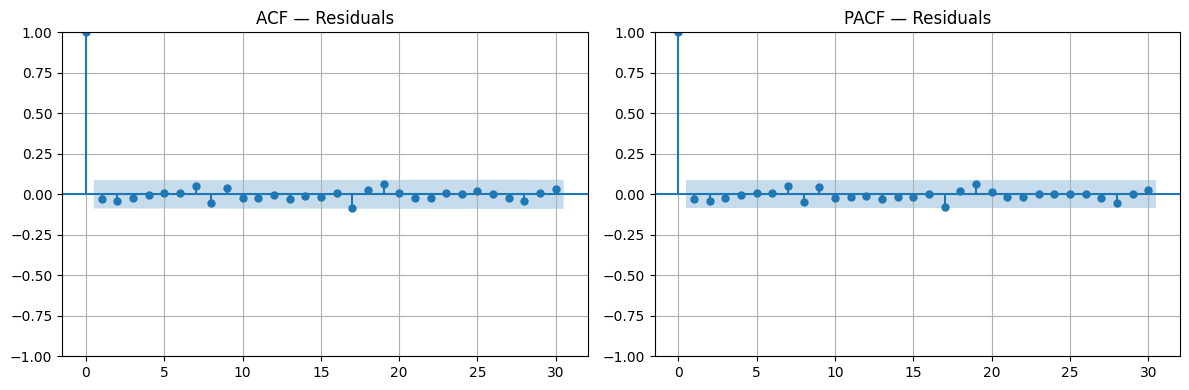


[Ljung–Box] ARIMA(1,1,1) Residuals
      LB stat   p-value                   decision@α=0.05
10   5.387462  0.863839  Fail to reject H0 → 근거 부족(유의 아님)
20  12.617293  0.893194  Fail to reject H0 → 근거 부족(유의 아님)

[Ljung–Box] Residuals^2 (ARCH check)
     LB stat  p-value                   decision@α=0.05
10  0.008892      1.0  Fail to reject H0 → 근거 부족(유의 아님)
20  0.056579      1.0  Fail to reject H0 → 근거 부족(유의 아님)


In [6]:

# ============================================================
# ARIMA(1,1,1) 적합 → 잔차 진단 (Ljung–Box: 잔차 & 잔차제곱)
# ============================================================
model = ARIMA(price, order=(1,1,1)).fit()
resid  = model.resid.dropna()

# 잔차 ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(resid, lags=30, ax=axes[0]); axes[0].set_title("ACF — Residuals")
plot_pacf(resid, lags=30, ax=axes[1], method="ywm"); axes[1].set_title("PACF — Residuals")
plt.tight_layout(); plt.show()

lb_resid   = ljungbox_report(resid,   "ARIMA(1,1,1) Residuals", lags=(10, 20), alpha=0.05)
lb_resid2  = ljungbox_report(resid**2, "Residuals^2 (ARCH check)", lags=(10, 20), alpha=0.05)



## 해석 가이드

- **Price(레벨)**: 대체로 p-value가 작아 H₀(자기상관 없음)를 기각 → 추세/느린 움직임 반영  
- **Log-Returns**: p-value가 큰 편이면 H₀ 기각 실패 → 단기 독립성(EMH와 일치)  
- **ARIMA 잔차**: p-value가 크면 모형이 자기상관을 잘 제거한 것  
- **Residuals²**: p-value가 작으면 **ARCH/변동성 군집** 징후 → GARCH류 모형 고려

> 시차(lags)는 10, 20 등 여러 값을 같이 제시하는 관습이 있으며, 표본 크기에 과도하게 크지 않게 선택하는 것이 좋습니다.
